In [1]:
import os
import cv2
import numpy
import pandas
import pprint
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from pathlib import Path
from torch import nn, optim
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
### Constants
TRAIN_PATH = "./dataset/train_data" # path to the dataset
TEST_PATH = "./dataset/test_data" # path to the dataset
VAL_PATH = "./dataset/val_data" # path to the dataset
LABEL_PATH = './media/labels.csv' # path to the labels csv file
# RESULT_PATH = "dataloader" + "_" + "max" + "_" + "3x5-3x3" + "_" + "old_dataset_defmodel" # path to the labels csv file
RESULT_PATH = "xx_dataloader" # path to the labels csv file
BATCH_SIZE_VAL = 50 # size of batches during training
N_EPOCHS = 100 # number of epochs for training
PATIENCE = 10 # number of epochs with no improvement after which training will stop
IMG_DIM = (32,32) # dimensions of the images (height, width, channels)

In [3]:
### Functions
def sorted_imagefolder(root, transform):
	# Ensure the folder names are sorted numerically, if find file ".DS_Store" remove it
	if ".DS_Store" in os.listdir(root):
		os.remove(os.path.join(root, ".DS_Store"))
	
	# Sort the folder names numerically
	folder_names = sorted(os.listdir(root), key=lambda x: int(x))

	# Create a mapping of folder names to numeric labels
	class_to_idx = {folder: idx for idx, folder in enumerate(folder_names)}

	# List to store valid image paths and labels
	valid_samples = []

	# Traverse the dataset and filter valid images
	for folder in folder_names:
		folder_path = os.path.join(root, folder)
		for file in os.listdir(folder_path):
			file_path = os.path.join(folder_path, file)
			# Check if the file is an image file
			try:
				with open(file_path, 'rb') as f:
					img = Image.open(f)
					img.verify()  # Verify if it's an image
				valid_samples.append((file_path, class_to_idx[folder]))  # Add valid image to list
			except (IOError, SyntaxError):  # Handle non-image files
				continue  # Ignore non-image files

	# Create an ImageFolder-like dataset but only with valid samples
	dataset = datasets.DatasetFolder(root=root, loader=Image.open, extensions=('jpg', 'jpeg', 'png'), transform=transform)
	
	# Update the dataset with valid samples and class_to_idx
	dataset.samples = valid_samples
	dataset.class_to_idx = class_to_idx
	dataset.classes = folder_names  # Set the sorted class names

	return dataset

def grayscale(img):
	"""function to convert the image to grayscale"""
	if isinstance(img, Image.Image):
		# If the image is in PIL format and not in grayscale mode, convert it
		if img.mode != 'L':
			img = img.convert('L')
	elif len(img.shape) == 3: # If it's a NumPy array with multiple channels (color)
		img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Convert to grayscale
	return img

def equalize(img):
	"""function to equalize the histogram for contrast adjustment"""
	# If it's a PIL Image, convert to NumPy array
	if isinstance(img, Image.Image):
		img = numpy.array(img)

	img = img.astype(numpy.uint8) # ensure the image is 8-bit grayscale
	img = cv2.equalizeHist(img) # apply histogram equalization
	return Image.fromarray(img)

def normalize(img):
	"""function to normalize the image (divide pixel values by 255)"""
	if isinstance(img, Image.Image):
		img = numpy.array(img)
	img = img / 255.0 # Scale pixel values to [0, 1]
	return Image.fromarray((img * 255).astype(numpy.uint8))

In [4]:
def tsd_model(n_classes):
	"""Defines the CNN model."""
	n_kernels = 60
	n_nodes = 500
	kernel_size_5x5 = (5, 5)
	kernel_size_3x3 = (3, 3)
	pool_size = (2, 2)
	dropout_rate = 0.5
	model = nn.Sequential(
		# First convolutional block
		nn.Conv2d(1, 32, kernel_size=kernel_size_5x5, padding=1),
		nn.BatchNorm2d(32),
		nn.ReLU(),
		nn.Conv2d(32, 64, kernel_size=kernel_size_5x5, padding=1),
		nn.BatchNorm2d(64),
		nn.ReLU(),
		nn.Conv2d(64, 32, kernel_size=kernel_size_5x5, padding=1),
		nn.BatchNorm2d(32),
		nn.ReLU(),
		nn.MaxPool2d(kernel_size=pool_size),

		# Second convolutional block
		nn.Conv2d(32, 64, kernel_size=kernel_size_3x3, padding=1),
		nn.BatchNorm2d(64),
		nn.ReLU(),
		nn.Conv2d(64, 64, kernel_size=kernel_size_3x3, padding=1),
		nn.BatchNorm2d(64),
		nn.ReLU(),
		nn.Conv2d(64, 32, kernel_size=kernel_size_3x3, padding=1),
		nn.BatchNorm2d(32),
		nn.ReLU(),
		nn.MaxPool2d(kernel_size=pool_size),
		nn.Dropout(dropout_rate),

		# Upsampling
		nn.ConvTranspose2d(32, 1, kernel_size=pool_size),  # Upsample with stride=2
		
		# Fully connected layers
		nn.Flatten(),  # Flatten the output from convolutional layers
		nn.Linear(32 * 8 * 8, n_nodes),  # Fully connected layer
		nn.ReLU(),
		nn.Dropout(dropout_rate),  # Dropout layer
		nn.Linear(n_nodes, n_classes),  # Output layer
		nn.Softmax(dim=1)  # Softmax for classification
	)

	return model

In [5]:
transform = transforms.Compose([
	transforms.Resize(IMG_DIM),  # Ensure the image is resized to 32x32
	transforms.Lambda(grayscale), # Convert to grayscale
	transforms.Lambda(equalize), # Equalize histogram
	transforms.Lambda(normalize), # Normalize pixel values
	# transforms.ToPILImage(), # Convert to PIL Image for torchvision compatibility
	transforms.RandomAffine(
		degrees=10, # Rotation range
		translate=(0.1, 0.1), # Width and height shift range (10%)
		scale=(0.8, 1.2), # Zoom range (0.8x to 1.2x)
		shear=10 # Shear range
	),
	transforms.ToTensor() # Convert to Tensor
])

# Split dataset into train, val, and test sets
train_dataset = sorted_imagefolder(TRAIN_PATH, transform)
test_dataset = sorted_imagefolder(TEST_PATH, transform)
val_dataset = sorted_imagefolder(VAL_PATH, transform)

# total number of classes
n_classes = len(train_dataset.classes)
print("Total Classes Detected:", n_classes)

Total Classes Detected: 38


In [6]:
# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_VAL, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE_VAL, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_VAL, shuffle=False)

# print the shapes of the datasets
print("Data Shapes")
print(f"Total imgs {sum([len(files) for r, d, files in os.walk("./dataset/")])}")
print("Train", len(train_loader.dataset)) # print training data shape
print("Validation", len(val_loader.dataset)) # print validation data shape
print("Test", len(test_loader.dataset)) # print test data shape

Data Shapes
Total imgs 39311
Train 31444
Validation 3914
Test 3914


data shape  (38, 2) <class 'pandas.core.frame.DataFrame'>
{0: {'id': 0, 'n': 146},
 1: {'id': 1, 'n': 1578},
 2: {'id': 2, 'n': 1563},
 3: {'id': 3, 'n': 977},
 4: {'id': 4, 'n': 1396},
 5: {'id': 5, 'n': 1289},
 6: {'id': 6, 'n': 1010},
 7: {'id': 7, 'n': 960},
 8: {'id': 8, 'n': 1025},
 9: {'id': 9, 'n': 881},
 10: {'id': 10, 'n': 1489},
 11: {'id': 11, 'n': 1505},
 12: {'id': 12, 'n': 642},
 13: {'id': 13, 'n': 515},
 14: {'id': 14, 'n': 571},
 15: {'id': 15, 'n': 1332},
 16: {'id': 16, 'n': 1289},
 17: {'id': 17, 'n': 277},
 18: {'id': 18, 'n': 466},
 19: {'id': 19, 'n': 702},
 20: {'id': 20, 'n': 514},
 21: {'id': 21, 'n': 688},
 22: {'id': 22, 'n': 402},
 23: {'id': 23, 'n': 1073},
 24: {'id': 24, 'n': 427},
 25: {'id': 25, 'n': 1291},
 26: {'id': 26, 'n': 630},
 27: {'id': 27, 'n': 281},
 28: {'id': 28, 'n': 1059},
 29: {'id': 29, 'n': 305},
 30: {'id': 30, 'n': 713},
 31: {'id': 31, 'n': 533},
 32: {'id': 32, 'n': 836},
 33: {'id': 33, 'n': 513},
 34: {'id': 34, 'n': 252},
 35:

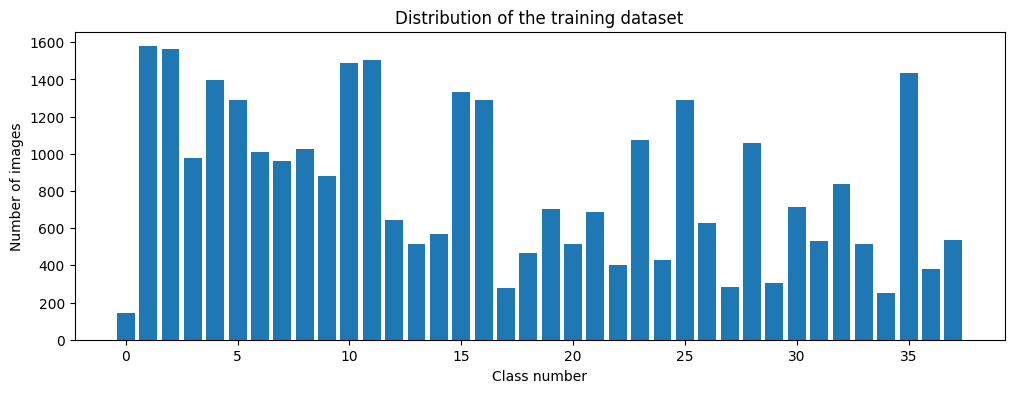

In [7]:
# read the label data from csv file
labels = pandas.read_csv(LABEL_PATH) # read the labels csv file
print("data shape ", labels.shape, type(labels))

# display some sample images from each class
sample_x_class =  {} # list for the number of samples per class

# Loop through each directory in the provided path
for class_dir in range(n_classes):
	# Full path to the subdirectory
	full_path = os.path.join(TRAIN_PATH, str(class_dir))
	num_dir = {}

	# Only proceed if it's a directory
	if os.path.isdir(full_path):
		num_dir['id'] = class_dir
		num_dir['n'] = len(os.listdir(full_path))
		sample_x_class[class_dir] = num_dir

# print the number of samples per class with the class name
pprint.pprint(sample_x_class)

sample_x_class_values = [item['n'] for item in sample_x_class.values()]

# plot the distribution of training dataset
plt.figure(figsize=(12, 4))
plt.bar(range(0, n_classes), sample_x_class_values) # create a bar chart for sample distribution
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

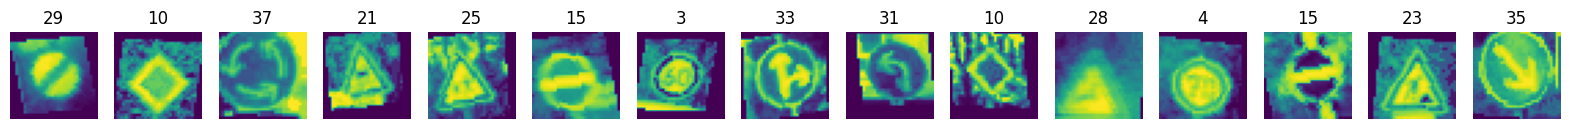

In [8]:
# Visualize some augmented images
data_iter = iter(train_loader)
images, labels = next(data_iter)

fig, axs = plt.subplots(1, 15, figsize=(20, 5))
for i in range(15):
	axs[i].imshow(images[i].permute(1, 2, 0).numpy()) # Unnormalize if necessary
	axs[i].set_title(train_dataset.classes[labels[i]])
	axs[i].axis('off')
plt.show()

In [9]:
# build and train the model
model = tsd_model(n_classes)
summary(model, (1, IMG_DIM[0], IMG_DIM[1]))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x49 and 2048x500)

In [ ]:
# from package import *
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
import time

# Funzione di addestramento
def train(model, train_loader, optimizer, epoch):
	model.train()
	epoch_loss = 0
	correct = 0
	total = 0
	start_time = time.time()

	for batch_idx, (data, target) in enumerate(train_loader):
		batch_start_time = time.time()
		data, target = data, target
		optimizer.zero_grad()
		output = model(data)
		loss = F.cross_entropy(output, target)
		loss.backward()
		optimizer.step()
		epoch_loss += loss.item()

		# Calcola l'accuratezza
		_, predicted = torch.max(output, 1)
		total += target.size(0)
		correct += (predicted == target).sum().item()

		batch_end_time = time.time()
		batch_elapsed_time = batch_end_time - batch_start_time
		total_elapsed_time = batch_end_time - start_time
		if batch_idx % 10 == 0:
			print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\t  Loss: {loss.item():.6f},  Batch Time: {batch_elapsed_time:.2f} seconds,  Total Time: {total_elapsed_time:.2f} seconds', end='\r')

	# Calcola l'accuratezza media per l'epoca
	accuracy = 100. * correct / total
	# Tempo totale per tutta l'epoca
	epoch_end_time = time.time()
	total_epoch_time = epoch_end_time - start_time

	print(f'\nTrain Epoch: {epoch} - Average loss: {epoch_loss / len(train_loader):.6f}, Accuracy: {accuracy:.2f}%, Total Time: {total_epoch_time:.2f} seconds')

	return epoch_loss / len(train_loader), accuracy

# Funzione di test o validazione
def val(model, val_loader):
	model.eval()
	test_loss = 0
	correct = 0
	start_time = time.time()
	with torch.no_grad():
		for data, target in val_loader:
			data, target = data, target
			output = model(data)
			test_loss += F.cross_entropy(output, target, reduction='sum').item()
			pred = output.argmax(dim=1, keepdim=True)
			correct += pred.eq(target.view_as(pred)).sum().item()
	end_time = time.time()
	test_loss /= len(val_loader.dataset)
	accuracy = 100. * correct / len(val_loader.dataset)
	print(f'Test/Validation set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(val_loader.dataset)} ({accuracy:.2f}%) - Time: {end_time - start_time:.2f} seconds')
	return test_loss, accuracy 

best_val_loss = 0
epochs_no_improve = 0
total_real_epoch = 0
train_accurs = []
val_accurs = []
train_losses = []
val_losses = []
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-2)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EPOCHS)

for epoch in range(1, N_EPOCHS + 1):
	total_real_epoch += 1
	print(f'\nEpoch {epoch}')
	# Allenamento del modello
	train_loss, train_accuracy = train(model, train_loader, optimizer, epoch)
	train_losses.append(train_loss)
	train_accurs.append(train_accuracy)

	# Test del modello e calcolo della loss e dell'accuracy
	val_loss, val_accuracy = val(model, val_loader)
	val_losses.append(val_loss)
	val_accurs.append(val_accuracy)

	# Aggiornamento del learning rate
	scheduler.step()
	current_lr = scheduler.get_last_lr()[0]
	print(f"Current learning rate: {current_lr:.6f}")

	# Salvataggio del miglior modello basato sulla loss
	if val_loss < best_val_loss:
		best_val_loss = val_loss
		best_model_state = model.state_dict()
		best_val_accuracy = val_accuracy
		epochs_no_improve = 0
		print(f"New best model found! Validation loss: {val_loss:.4f}, Validation accuracy: {val_accuracy:.2f}%")

		# Salva i pesi del miglior modello
		torch.save(best_model_state, 'model_weights.pth')
		print(f"Best model weights saved with validation loss: {best_val_loss:.4f} and validation accuracy: {best_val_accuracy:.2f}%")
	else:
		epochs_no_improve += 1
		print("Epoch without improvment: " + str(epochs_no_improve))

	# Controllo se fermarmi
	if epochs_no_improve >= PATIENCE:
		print("Early stopping")
		break

In [ ]:
# Plotting the loss and accuracy
epochs = range(1, N_EPOCHS+1)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# print last validation loss and accuracy from saved model
# model = tsd_model(n_classes)
# model.load_weights(RESULT_PATH+".keras") # load the best model
# loss, accuracy = model.evaluate(X_val, y_val, verbose=0) # evaluate the model
# print(f'Last Validation Loss from Saved Model: {loss}')
# print(f'Last Validation Accuracy from Saved Model: {accuracy}')

# Load the best model
model.load_state_dict(torch.load(best_model_path))
print("Best model loaded.")

# Set model to evaluation mode
model.eval()

# Initialize loss function and any metrics you want to track
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for multi-class classification

# Variables to keep track of test loss and accuracy
test_loss = 0.0
correct_predictions = 0
total_predictions = 0

# Evaluation loop
with torch.no_grad(): # Disable gradient computation for evaluation
	for images, labels in test_loader:
		images, labels = images, labels # Move to GPU if available

		# Forward pass
		outputs = model(images)

		# Calculate loss
		loss = criterion(outputs, labels)
		test_loss += loss.item() # Accumulate loss

		# Calculate accuracy
		_, predicted = torch.max(outputs, 1) # Get the index of the max log-probability
		correct_predictions += (predicted == labels).sum().item() # Count correct predictions
		total_predictions += labels.size(0) # Update total number of predictions

# Calculate average loss and accuracy
average_loss = test_loss / len(test_loader)
accuracy = correct_predictions / total_predictions * 100

# Print the results
print(f"Test Loss: {average_loss}, Test Accuracy: {accuracy}%")